<a href="https://colab.research.google.com/github/ro200227/BlurredImage_Detection/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing Dataset Using Kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kwentar/blur-dataset")


print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/blur-dataset


In [3]:
#importing libraries
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [7]:
#set paths
import os
base_path = "/kaggle/input/blur-dataset"

sharp_dir = os.path.join(base_path, "sharp")
defocused_dir = os.path.join(base_path, "defocused_blurred")
motion_dir = os.path.join(base_path, "motion_blurred")

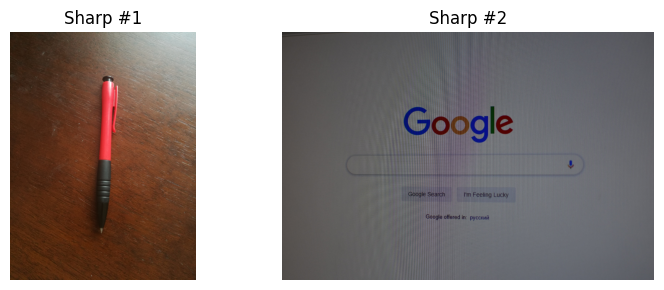

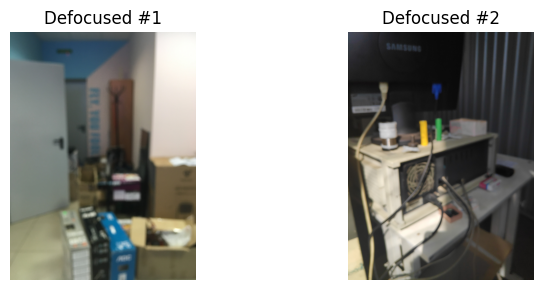

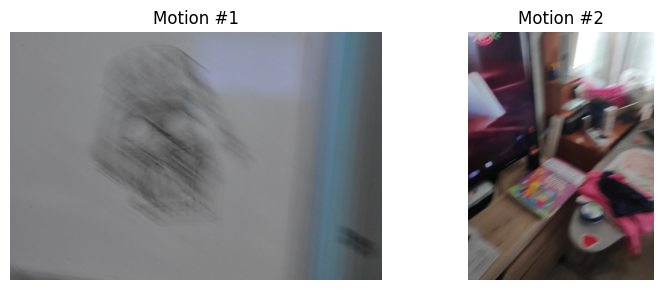

In [8]:
#displaying images
def show_images_from_dir(directory, title, num_images=2):
    image_files = os.listdir(directory)[:num_images]
    plt.figure(figsize=(8, 3))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(directory, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} #{i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show 2 images from each class
show_images_from_dir(sharp_dir, "Sharp", num_images=2)
show_images_from_dir(defocused_dir, "Defocused", num_images=2)
show_images_from_dir(motion_dir, "Motion", num_images=2)

In [9]:
# Feature Extraction Functions
def compute_laplacian_var(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def compute_fft_mean(image, size=60):
    fft = np.fft.fft2(image)
    fft_shift = np.fft.fftshift(fft)
    magnitude = 20 * np.log(np.abs(fft_shift))
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-size:crow+size, ccol-size:ccol+size] = 1
    return np.mean(magnitude * mask)

def compute_edge_density(image, threshold=50):
    edges = cv2.Canny(image, threshold, threshold*2)
    return np.sum(edges > 0) / (image.shape[0] * image.shape[1])

In [10]:
# Loading dataset and extracting features
def load_dataset(sharp_dir, defocused_dir, motion_dir, sample_size=500):
    features = []
    labels = []

    # Label encoding: 0=sharp, 1=defocused, 2=motion
    for label, dir_path in enumerate([sharp_dir, defocused_dir, motion_dir]):
        count = 0
        for img_file in os.listdir(dir_path)[:sample_size]:
            img_path = os.path.join(dir_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize for consistency
            img = cv2.resize(img, (256, 256))

            # Extracting features
            laplacian = compute_laplacian_var(img)
            fft_mean = compute_fft_mean(img)
            edge_density = compute_edge_density(img)

            features.append([laplacian, fft_mean, edge_density])
            labels.append(label)
            count += 1

        print(f"Loaded {count} images from {os.path.basename(dir_path)}")

    return np.array(features), np.array(labels)

In [11]:
features, labels = load_dataset(sharp_dir, defocused_dir, motion_dir, sample_size=500)

Loaded 350 images from sharp
Loaded 350 images from defocused_blurred
Loaded 350 images from motion_blurred


In [20]:
#model building
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Training using Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [21]:
#Evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['sharp', 'defocused', 'motion']))

Accuracy: 0.8857142857142857

Classification Report:
              precision    recall  f1-score   support

       sharp       0.90      0.96      0.93        76
   defocused       0.93      0.89      0.91        72
      motion       0.82      0.79      0.80        62

    accuracy                           0.89       210
   macro avg       0.88      0.88      0.88       210
weighted avg       0.89      0.89      0.88       210



<Figure size 600x400 with 0 Axes>

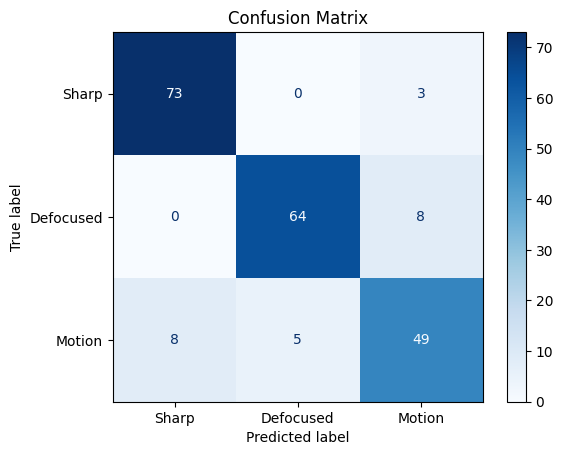

In [22]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
class_names = ['Sharp', 'Defocused', 'Motion']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


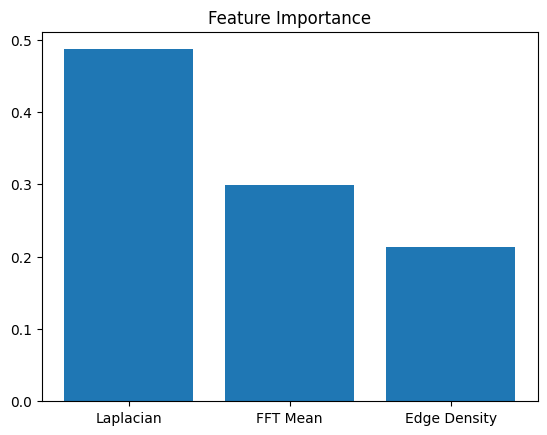

In [23]:
# Feature Importance Visualization
plt.bar(['Laplacian', 'FFT Mean', 'Edge Density'], clf.feature_importances_)
plt.title("Feature Importance")
plt.show()

In [24]:
#Model Saving
import pickle

with open("blur_detection_model.pkl", "wb") as f:
    pickle.dump(clf, f)

print("Model saved as blur_detection_model.pkl")

Model saved as blur_detection_model.pkl


In [29]:
#PREDICTIONS

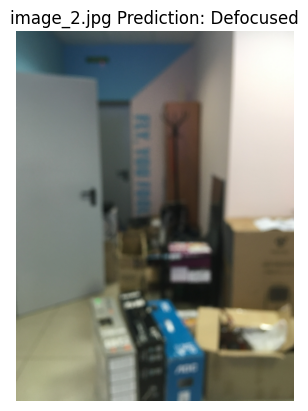

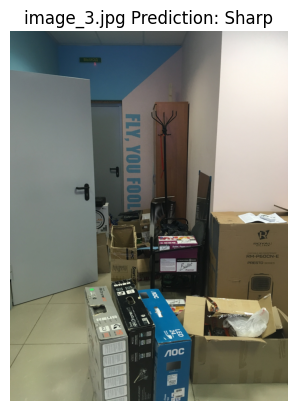

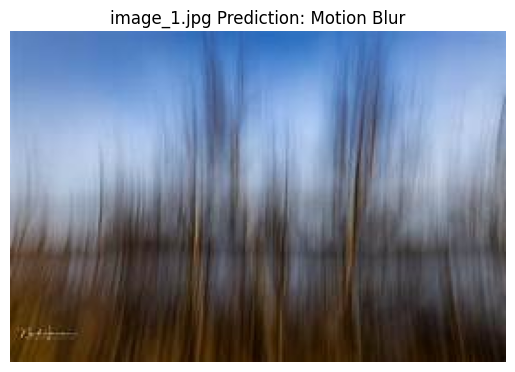

In [27]:
import cv2
import numpy as np
import joblib
import os
from matplotlib import pyplot as plt

# Load model
model = joblib.load("blur_detection_model.pkl")

# Class mapping
classes = {0: 'Sharp', 1: 'Defocused', 2: 'Motion Blur'}

# Feature extractor
def compute_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    image = cv2.resize(image, (256, 256))

    laplacian = cv2.Laplacian(image, cv2.CV_64F).var()

    fft = np.fft.fft2(image)
    fft_shift = np.fft.fftshift(fft)
    magnitude = 20 * np.log(np.abs(fft_shift) + 1e-10)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols))
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    fft_mean = np.mean(magnitude * mask)

    edges = cv2.Canny(image, 50, 100)
    edge_density = np.mean(edges > 0)

    return [laplacian, fft_mean, edge_density]

# Prediction
def predict_folder(folder_path):
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)
            if img is None:
                print(f"{file} - Failed to load")
                continue

            features = compute_features(img)
            pred = model.predict([features])[0]
            label = classes[pred]

            # Show result
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"{file} Prediction: {label}")
            plt.axis('off')
            plt.show()

predict_folder("Data_Images")
